# CIFAR-10: Training and Testing on a Clean Dataset & Adversarial Analysis

## Imports and CIFAR-10 loading

In [1]:
# For loading model sanely
import os.path

# For plotting
import torch
import torch.nn as nn
from tqdm.notebook import tnrange, tqdm

# DNN used
import models.resnet as resnet

# Test the loaded model
import utils.clean_test as clean_test

In [2]:
# Define the `device` PyTorch will be running on, please hope it is CUDA
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Notebook will use PyTorch Device: " + device.upper())

Notebook will use PyTorch Device: CUDA


## Training, Validation and Testing

In [3]:
# Get the data loaders (assume we do no validation)
import utils.dataloaders as dataloaders

DATA_ROOT = "./datasets/"

trainSetLoader, _, testSetLoader = dataloaders.get_CIFAR10_data_loaders(
    DATA_ROOT,
    trainSetSize=50000,
    validationSetSize=0,
)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [4]:
# This method creates a new model and also trains it
def get_trained_model(load_if_available=False):
    # Helps adjust learning rate for better results
    def adjust_learning_rate(optimizer, epoch, learning_rate):
        actual_learning_rate = learning_rate
        if epoch >= 100:
            actual_learning_rate = 0.01
        if epoch >= 150:
            actual_learning_rate = 0.001
        for param_group in optimizer.param_groups:
            param_group["lr"] = actual_learning_rate

    # Various training parameters
    epochs = 200
    learning_rate = 0.1

    # Network parameters
    loss_function = nn.CrossEntropyLoss()
    model = resnet.ResNet18()
    model = model.to(device)
    model = nn.DataParallel(model)

    # Consider using ADAM here as another gradient descent algorithm
    optimizer = torch.optim.SGD(
        model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002
    )

    # If a trained model already exists, give up the training part
    if load_if_available and os.path.isfile("./cifar10_model"):
        print("Found already trained model")

        model = torch.load("./cifar10_model")

        # Return the loaded model
        return model

    print("Training the model...")
    model.train()

    # Use a pretty progress bar to show updates
    for epoch in tnrange(epochs, desc="Training Progress"):
        # Adjust the learning rate
        adjust_learning_rate(optimizer, epoch, learning_rate)

        for _, (images, labels) in enumerate(tqdm(trainSetLoader, desc="Batches")):
            # Cast to proper tensors
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            logits = model(images)

            loss = loss_function(logits, labels)
            loss.backward()

            optimizer.step()

        model.eval()
        clean_test.test_trained_model(model, testSetLoader)
        model.train()

    print("... done!")

    # Return the trained model
    return model

## Putting it all together (the 'main')

In [5]:
model = get_trained_model(load_if_available=True)

Found already trained model


In [6]:
clean_test.test_trained_model(model, testSetLoader)

Testing the model...


Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 94.1%


In [7]:
# Save the model
torch.save(model, "./cifar10_model")

## Attacks and Their Results

In [8]:
# A possible attacks array (for nice printing):
import utils.attacking as attacking

# For printing outcomes
import utils.printing as printing

attacks = {}

### FGSM (Fast Sign Gradient Method) https://arxiv.org/abs/1412.6572

The formula that is used for producing the adversarial example in this case is:

$x' = x + \epsilon * sign(\nabla_{x}J(\theta, x, y))$, where J is the loss function used.

In [9]:
import attacks.fgsm as fgsm

attacks["FGSM"] = fgsm.fgsm_attack

In [10]:
# Several values to use for the epsilons
epsilons = [0, 0.05, 0.1, 0.2, 0.35, 0.55, 0.75, 1]

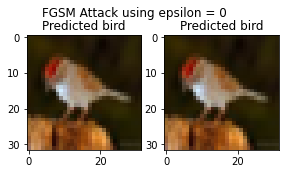

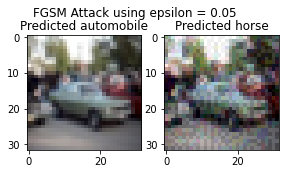

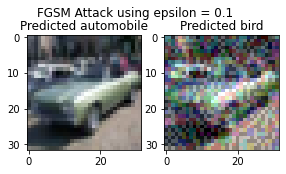

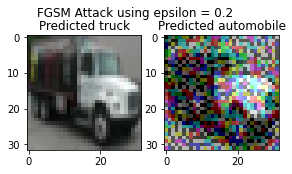

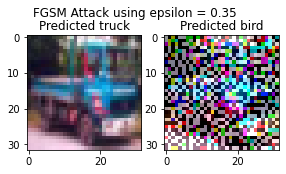

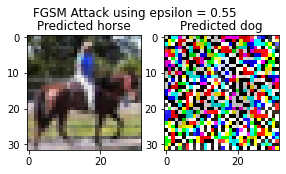

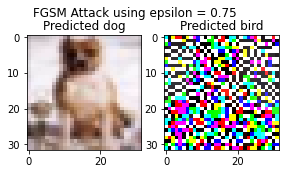

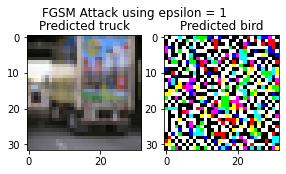

In [11]:
for epsilon in epsilons:
    printing.print_attack(
        model,
        testSetLoader,
        "FGSM",
        attacks["FGSM"],
        epsilon=epsilon,
    )

In [12]:
# Run test for each epsilon
for epsilon in epsilons:
    attacking.attack_model(
        model,
        testSetLoader,
        "FGSM",
        attacks["FGSM"],
        epsilon=epsilon,
    )

Testing the model under FGSM Attack using epsilon = 0, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 94.1%


Testing the model under FGSM Attack using epsilon = 0.05, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 61.34%


Testing the model under FGSM Attack using epsilon = 0.1, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 50.81%


Testing the model under FGSM Attack using epsilon = 0.2, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 35.37%


Testing the model under FGSM Attack using epsilon = 0.35, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 22.94%


Testing the model under FGSM Attack using epsilon = 0.55, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 15.66%


Testing the model under FGSM Attack using epsilon = 0.75, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 12.39%


Testing the model under FGSM Attack using epsilon = 1, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 11.32%




### I-FGSM / BIM (Iterative FGSM / Basic Iterative Method) https://arxiv.org/abs/1607.02533

The formula that is used for producing the adversarial example in this case is:

$x'_{0} = x$
$x'_{k + 1} = Clip_{x, \epsilon} \{x'_{k} + \alpha * sign(\nabla_{x}J(\theta, x'_{k}, y)\}$, where J is the loss function used. Note that in the paper proposing this method, $\alpha = 1$ is used, so pixels are changed by 1 in each iteration.

The formula for the clip function is also given in the paper.

In [13]:
import attacks.ifgsm as ifgsm

attacks["I-FGSM"] = ifgsm.ifgsm_attack

In [14]:
# Several values for epsilon. It's interesting to see how clamping affects results
epsilons = [0, 4 / 255, 0.05, 0.1]

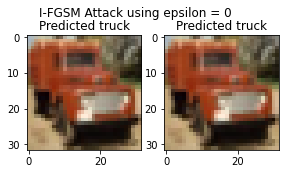

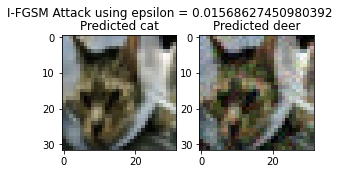

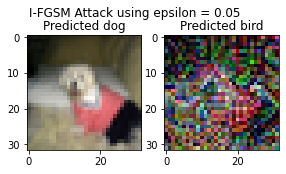

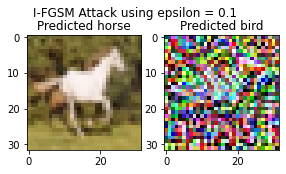

In [15]:
for epsilon in epsilons:
    printing.print_attack(
        model,
        testSetLoader,
        "I-FGSM",
        attacks["I-FGSM"],
        epsilon=epsilon,
        alpha=1,
        iterations=0,
    )

In [16]:
for epsilon in epsilons:
    attacking.attack_model(
        model,
        testSetLoader,
        "I-FGSM",
        attacks["I-FGSM"],
        epsilon=epsilon,
        alpha=1,
        iterations=0,
    )

Testing the model under I-FGSM Attack using epsilon = 0, alpha = 1...


I-FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 94.1%


Testing the model under I-FGSM Attack using epsilon = 0.01568627450980392, alpha = 1...


I-FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 15.52%


Testing the model under I-FGSM Attack using epsilon = 0.05, alpha = 1...


I-FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 0.03%


Testing the model under I-FGSM Attack using epsilon = 0.1, alpha = 1...


I-FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 0.0%




### PGD (Projected Gradient Descent) https://arxiv.org/pdf/1706.06083.pdf

The formula that is used for producing the adversarial example in this case is:

$x^{t+1} = \Pi_{x+S}(x^t+\alpha sgn(\bigtriangledown_x L(\theta, x, y)))$\n
where S is a set of allowed perturbations. Note that this is basically BIM with random initialisation. 

We use the $L_{\infty}$ norm here, i.e. we use clamping. 

In [17]:
import attacks.pgd as pgd

In [18]:
attacks["PGD"] = pgd.pgd_attack

In [19]:
# Several values to use for the epsilons
epsilons = [0, 4 / 255, 0.05, 0.1, 0.2, 0.35]

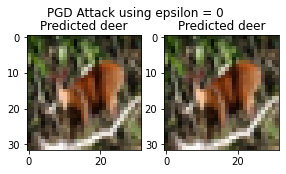

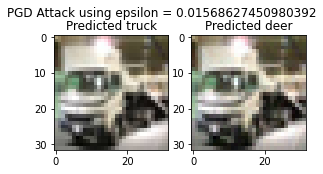

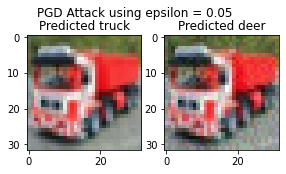

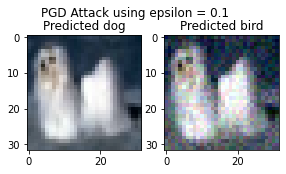

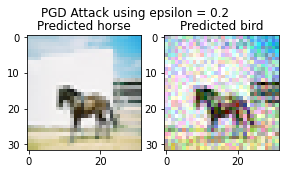

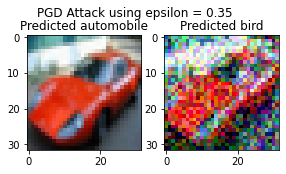

In [20]:
for epsilon in epsilons:
    printing.print_attack(
        model,
        testSetLoader,
        "PGD",
        attacks["PGD"],
        epsilon=epsilon,
        alpha=(2 / 255),
        iterations=20,
    )

In [21]:
for epsilon in epsilons:
    attacking.attack_model(
        model,
        testSetLoader,
        "PGD",
        attacks["PGD"],
        epsilon=epsilon,
        alpha=(2 / 255),
        iterations=20,
    )

Testing the model under PGD Attack using epsilon = 0, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 94.1%


Testing the model under PGD Attack using epsilon = 0.01568627450980392, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 8.09%


Testing the model under PGD Attack using epsilon = 0.05, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 0.55%


Testing the model under PGD Attack using epsilon = 0.1, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 0.22%


Testing the model under PGD Attack using epsilon = 0.2, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 0.03%


Testing the model under PGD Attack using epsilon = 0.35, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 0.0%




## From here, use existing libraries to simplify usageimport torchattacks


In [22]:
import torchattacks

### CW-$L_{2}$ (Carlini & Wagner using $L_{2}$ norm) https://arxiv.org/pdf/1608.04644.pdf

The formula here is complex, so I recommend for the interested reader to go the above link to read the full paper.

In [23]:
cw_attack = torchattacks.CW(model, c=25)

attacks["CW"] = cw_attack

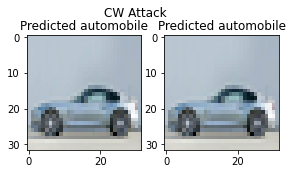

In [24]:
printing.print_attack(model, testSetLoader, "CW", attacks["CW"], library=True)

In [25]:
attacking.attack_model(
    model,
    testSetLoader,
    "CW",
    attacks["CW"],
    library=True,
)

Testing the model under CW Attack...


CW Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 20.55%


